# Capstone Project - The Battle of Neighborhoods (Week 2) in Toronto

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Conclusion](#conclusion)

## Introduction/Business Problem<a name="introduction"></a>

Clearly define a problem or an idea of your choice, where you would need to leverage the Foursquare location data to solve or execute. Remember that data science problems always target an audience and are meant to help a group of stakeholders solve a problem, so make sure that you explicitly describe your audience and why they would care about your problem.

The purpose of this project is to help people planning to open a new restaurant in Toronto to chose the right location by providing data about the income and population of each neighborhood as well as the competitors already present on the same regions.

Lots of people are migrating to various states of Canada and needed lots of research for good opening a Business like a restaurant. This project is for those people who are looking for better neighborhoods. For ease of accessing to a restaurant.

This project aims to create an analysis of features for people migrating to Scarborough to search the best neighborhood as a comparative analysis between neighborhoods.

It will help people who have businesses to get awareness of the area and neighborhood before moving to a new city, state, country, or place for their work and business.

So the Problem Which Tried to Solve:

The major purpose of this project is to suggest a better neighborhood in a new city for the person who is shifting there to open a new business. Sorted list of restaurants in terms of restaurant prices in an ascending or descending order.

## Data <a name="data"></a>

Data Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

for population: https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods 
             
Will use Scarborough dataset which we scrapped from wikipedia on Week 3. Dataset consisting of latitude and longitude, zip codes.

We will need data about different venues in different neighborhoods of that specific borough. To gain that information we will use "Foursquare" locational information. Foursquare is a location data provider with information about all manner of venues and events within an area of interest. Such information includes venue names, locations, menus, and even photos. As such, the foursquare location platform will be used as the sole data source since all the stated required information can be obtained through the API.

After finding the list of neighborhoods, we then connect to the Foursquare API to gather information about venues inside each neighborhood. For each neighborhood, we have chosen the radius to be 100 meters.

The data retrieved from Foursquare contained information of venues within a specified distance of the longitude and latitude of the postcodes. The information obtained per venue as follows:

1. Neighborhood
2. Neighborhood Latitude
3. Neighborhood Longitude
4. Venue
5. Name of the venue e.g. the name of a restaurant
6. Venue Latitude
7. Venue Longitude
8. Venue Category

### Importing libraries

In [81]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

# !conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

### Building the Dataframe

In [82]:
# pip install lxml
import lxml
toronto_raw = pd.read_html("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")

### Toronto_raw is a list and we need to convert it into dataframe.

In [84]:
tdf = pd.DataFrame(toronto_raw[0])
tdf.shape

(180, 3)

In [85]:
tdf['Borough'].unique()

array(['Not assigned', 'North York', 'Downtown Toronto', 'Etobicoke',
       'Scarborough', 'East York', 'York', 'East Toronto', 'West Toronto',
       'Central Toronto', 'Mississauga'], dtype=object)

In [86]:
tdf.head(1)

,Postal Code,Borough,Neighborhood
0,M1A,Not assigned,Not assigned


In [87]:
# Step1: Remove space in column name
tdf.columns = ['PostalCode', 'Borough', 'Neighborhood']

# Step2: Ignore cells with Borough == 'Not assigned'
tdf = tdf[tdf.Borough != 'Not assigned']

# Step3: For cells whose neighborhood == 'Not assigned', replace it with the Borough
tdf['Neighborhood'][tdf.Neighborhood == 'Not assigne'] = tdf['Borough']

# Step4: Combine boroughes which have same postal code into one row
tdf = tdf.groupby(['PostalCode', 'Borough'])['Neighborhood'].apply(','.join).reset_index()

tdf.head()

,PostalCode,Borough,Neighborhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


#### The shape of the dataframe 'tdf' is:

In [88]:
tdf.shape

(103, 3)

## Get the latitude and the longitude coordinates of each neighborhood

In [90]:
csv_path = ('http://cocl.us/Geospatial_data')
geo_df = pd.read_csv(csv_path)

In [91]:
geo_df.columns = ['PostalCode', 'Latitude', 'Longitude']
geo_df.head()

,PostalCode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [92]:
geo_df.dtypes

PostalCode     object
Latitude      float64
Longitude     float64
dtype: object

In [93]:
tdf.dtypes

PostalCode      object
Borough         object
Neighborhood    object
dtype: object

In [94]:
toronto_geo_df = tdf.merge(geo_df, on=['PostalCode'], how='left')

### Tronoto dataframe with latitude and logitude of each neighborhood added

#### CHECK: to make sure the coordiante are added by required

In [95]:
column_names = ["PostalCode", "Borough", "Neighborhood", "Latitude", "Longitude"]
test_df = pd.DataFrame(columns=column_names)

test_list = ["M5G", "M2H", "M4B", "M1J", "M4G", "M4M", "M1R", "M9V", "M9L", "M5V", "M1B", "M5A"]

for postcode in test_list:
    test_df = test_df.append(toronto_geo_df[toronto_geo_df["PostalCode"]==postcode], ignore_index=True)
    
test_df

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
1,M2H,North York,Hillcrest Village,43.803762,-79.363452
2,M4B,East York,"Parkview Hill, Woodbine Gardens",43.706397,-79.309937
3,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
4,M4G,East York,Leaside,43.709060,-79.363452
5,M4M,East Toronto,Studio District,43.659526,-79.340923
6,M1R,Scarborough,"Wexford, Maryvale",43.750072,-79.295849
7,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437
8,M9L,North York,Humber Summit,43.756303,-79.565963
9,M5V,Downtown Toronto,"CN Tower, King and Spadina, Railway Lands, Har...",43.628947,-79.394420


In [96]:
toronto_geo_df.head(10)

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"Kennedy Park, Ionview, East Birchmount Park",43.727929,-79.262029
7,M1L,Scarborough,"Golden Mile, Clairlea, Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffside, Cliffcrest, Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff, Cliffside West",43.692657,-79.264848


In [97]:
toronto_geo_df.shape

(103, 5)

##  Explore and cluster the neighborhoods in Toronto

### Using Geopy library to get the coordiante of Toronto

In [98]:
address = 'Toronto, Canada'

geolocator = Nominatim(user_agent="toronto_explorer")
# Or you can use:
    # address = 'Toronto, ON'
    # geolocator = Nominatim(user_agent="ny_explorer")
    
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto are 43.6534817, -79.3839347.


### Create a map of Toronto with neighborhoods superimposed on top.

In [99]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_geo_df['Latitude'], toronto_geo_df['Longitude'], toronto_geo_df['Borough'], toronto_geo_df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,  # you can edit it as you like
        popup=label,
        color='blue', # you can edit it as you like
        fill=True,
        fill_color='#3186cc',  # you can edit it as you like
        fill_opacity=0.7,   # you can edit it as you like
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### For time saving, all analysis below are made with only boroughs that contain the word Toronto

In [100]:
# filter broughs that contain the word Toronto
toronto_analyse = toronto_geo_df[toronto_geo_df['Borough'].str.contains('Toronto')]

In [101]:
toronto_analyse['Borough'].unique(), toronto_analyse.shape

(array(['East Toronto', 'Central Toronto', 'Downtown Toronto',
        'West Toronto'], dtype=object),
 (39, 5))

In [102]:
toronto_analyse.head()
# toronto_analyse

,PostalCode,Borough,Neighborhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [103]:
# create map of Toronto using latitude and longitude values
map_toronto1 = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, borough, neighborhood in zip(toronto_analyse['Latitude'], toronto_analyse['Longitude'], toronto_analyse['Borough'], toronto_analyse['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3199cc',
        fill_opacity=0.3,
        parse_html=False).add_to(map_toronto1) 
    
map_toronto1

### Define Foursquare Credentials and Version

In [104]:
CLIENT_ID = 'IYSVOSFEOSQDSDO5R5FDRTZJL1UERDLCIPJKSXL4C2O55MPK' # your Foursquare ID
CLIENT_SECRET = 'ZVF3WSF43Y4HYRMJCOIAWFY1WGZ5YPJKVC5BUD5G4QXIPNF0' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IYSVOSFEOSQDSDO5R5FDRTZJL1UERDLCIPJKSXL4C2O55MPK
CLIENT_SECRET:ZVF3WSF43Y4HYRMJCOIAWFY1WGZ5YPJKVC5BUD5G4QXIPNF0


In [105]:
# Explore the first neighborhood
# In toronto_analyse data 37 = 0 = first neighborhood
toronto_analyse.loc[37, 'Neighborhood']

'The Beaches'

#### let's grab the neighbourhood long and lat values

In [106]:
# Explore the data, and get the venues in 500 meters range from our first entry
neighborhood_latitude = toronto_analyse.loc[37, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = toronto_analyse.loc[37, 'Longitude'] # neighborhood longitude value

neighborhood_name = toronto_analyse.loc[37, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of The Beaches are 43.67635739999999, -79.2930312.


#### Create the GET request URL
Let's see what the top 100 venus are within a radius from the centroid of 500 meters

In [107]:
# Create the GET request URL
LIMIT = 100
radius = 500
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=IYSVOSFEOSQDSDO5R5FDRTZJL1UERDLCIPJKSXL4C2O55MPK&client_secret=ZVF3WSF43Y4HYRMJCOIAWFY1WGZ5YPJKVC5BUD5G4QXIPNF0&v=20180605&ll=43.67635739999999,-79.2930312&radius=500&limit=100'

In [108]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5f105fc4d34c0476cc43533d'},
 'response': {'headerLocation': 'The Beaches',
  'headerFullLocation': 'The Beaches, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 4,
  'suggestedBounds': {'ne': {'lat': 43.680857404499996,
    'lng': -79.28682091449052},
   'sw': {'lat': 43.67185739549999, 'lng': -79.29924148550948}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4bd461bc77b29c74a07d9282',
       'name': 'Glen Manor Ravine',
       'location': {'address': 'Glen Manor',
        'crossStreet': 'Queen St.',
        'lat': 43.67682094413784,
        'lng': -79.29394208780985,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.67682094413784,
          'lng': -79.29394208780985}],
        'distanc

In [109]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### Clean json and structure into a pandas dataframe

In [110]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Glen Manor Ravine,Trail,43.676821,-79.293942
1,The Big Carrot Natural Food Market,Health Food Store,43.678879,-79.297734
2,Grover Pub and Grub,Pub,43.679181,-79.297215
3,Upper Beaches,Neighborhood,43.680563,-79.292869


### Using the funtion from LAB to explore each borough

In [111]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### Run the above function on each neighborhood and create a new dataframe called toronto_venues

In [112]:
toronto_venues = getNearbyVenues(names=toronto_analyse['Neighborhood'],
                                   latitudes=toronto_analyse['Latitude'],
                                   longitudes=toronto_analyse['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
India Bazaar, The Beaches West
Studio District
Lawrence Park
Davisville North
North Toronto West, Lawrence Park
Davisville
Moore Park, Summerhill East
Summerhill West, Rathnelly, South Hill, Forest Hill SE, Deer Park
Rosedale
St. James Town, Cabbagetown
Church and Wellesley
Regent Park, Harbourfront
Garden District, Ryerson
St. James Town
Berczy Park
Central Bay Street
Richmond, Adelaide, King
Harbourfront East, Union Station, Toronto Islands
Toronto Dominion Centre, Design Exchange
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North & West, Forest Hill Road Park
The Annex, North Midtown, Yorkville
University of Toronto, Harbord
Kensington Market, Chinatown, Grange Park
CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport
Stn A PO Boxes
First Canadian Place, Underground city
Christie
Dufferin, Dovercourt Village
Little Portugal, Trinity
Brockton, Parkdale Village, Exhibition Place
High 

### Check the size of toronto_venues

In [113]:
print(toronto_venues.shape)
toronto_venues.head()

(1628, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop


### Let's check how many venues were returned for each neighborhood

In [114]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Berczy Park,57,57,57,57,57,57
"Brockton, Parkdale Village, Exhibition Place",24,24,24,24,24,24
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",17,17,17,17,17,17
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",16,16,16,16,16,16
Central Bay Street,70,70,70,70,70,70
Christie,17,17,17,17,17,17
Church and Wellesley,71,71,71,71,71,71
"Commerce Court, Victoria Hotel",100,100,100,100,100,100
Davisville,33,33,33,33,33,33


In [115]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 229 uniques categories.


### Analyse each neighborhood

In [116]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]
# toronto_onehot.head()

### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [117]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()

### Let's print each neighborhood along with the top 5 most common venues

In [118]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')


----Berczy Park----
          venue  freq
0   Coffee Shop  0.07
1  Cocktail Bar  0.05
2          Café  0.04
3   Cheese Shop  0.04
4        Bakery  0.04


----Brockton, Parkdale Village, Exhibition Place----
                    venue  freq
0                    Café  0.12
1             Yoga Studio  0.08
2             Coffee Shop  0.08
3          Breakfast Spot  0.08
4  Furniture / Home Store  0.04


----Business reply mail Processing Centre, South Central Letter Processing Plant Toronto----
                venue  freq
0  Light Rail Station  0.12
1         Pizza Place  0.06
2       Auto Workshop  0.06
3       Garden Center  0.06
4              Garden  0.06


----CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport----
              venue  freq
0   Airport Service  0.19
1    Airport Lounge  0.12
2  Airport Terminal  0.12
3   Harbor / Marina  0.06
4           Airport  0.06


----Central Bay Street----
                 venue  freq
0      

In [119]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [120]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Pharmacy,Bakery,Restaurant,Beer Bar,Seafood Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Yoga Studio,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Park,Pizza Place,Smoke Shop,Brewery,Spa,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Coffee Shop,Harbor / Marina,Boutique,Sculpture Garden,Airport Gate,Airport Food Court
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Department Store,Bar


### Cluster the neighborhood

In [121]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 4])

### Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [122]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_.astype("int"))

toronto_merged = toronto_analyse

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood').dropna()

toronto_merged.head() # check the last columns!

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
42,M4L,East Toronto,"India Bazaar, The Beaches West",43.668999,-79.315572,0,Park,Fish & Chips Shop,Pub,Liquor Store,Sandwich Place,Burrito Place,Italian Restaurant,Intersection,Restaurant,Steakhouse
43,M4M,East Toronto,Studio District,43.659526,-79.340923,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790,2,Park,Swim School,Bus Line,Ethiopian Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run


### Let's visualize the resulting clusters

In [123]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
# for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'], toronto_merged['Cluster Labels']):    
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### We can see that, for bouroughs which contains 'Toronto', almost all of them are in the same cluster, cluster 1 which are areas with cafe, restaurant, supermarket etc.

In [124]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,0,Trail,Health Food Store,Pub,Women's Store,Dance Studio,Eastern European Restaurant,Dumpling Restaurant,Donut Shop,Doner Restaurant,Dog Run
41,East Toronto,0,Greek Restaurant,Coffee Shop,Italian Restaurant,Furniture / Home Store,Restaurant,Ice Cream Shop,Cosmetics Shop,Brewery,Bubble Tea Shop,Café
42,East Toronto,0,Park,Fish & Chips Shop,Pub,Liquor Store,Sandwich Place,Burrito Place,Italian Restaurant,Intersection,Restaurant,Steakhouse
43,East Toronto,0,Café,Coffee Shop,Gastropub,Bakery,Brewery,American Restaurant,Seafood Restaurant,Sandwich Place,Cheese Shop,Pet Store
46,Central Toronto,0,Clothing Store,Coffee Shop,Sporting Goods Shop,Yoga Studio,Bagel Shop,Gift Shop,Fast Food Restaurant,Diner,Mexican Restaurant,Pet Store
47,Central Toronto,0,Dessert Shop,Sandwich Place,Gym,Italian Restaurant,Café,Pizza Place,Sushi Restaurant,Coffee Shop,Pharmacy,Brewery
49,Central Toronto,0,Pub,Coffee Shop,Pizza Place,Liquor Store,Sports Bar,Bank,Restaurant,Supermarket,Sushi Restaurant,Fried Chicken Joint
51,Downtown Toronto,0,Coffee Shop,Restaurant,Italian Restaurant,Pizza Place,Bakery,Café,Pub,Park,Chinese Restaurant,Pharmacy
52,Downtown Toronto,0,Coffee Shop,Sushi Restaurant,Japanese Restaurant,Gay Bar,Restaurant,Yoga Studio,Pub,Hotel,Mediterranean Restaurant,Men's Store
53,Downtown Toronto,0,Coffee Shop,Bakery,Park,Pub,Breakfast Spot,Café,Theater,Chocolate Shop,Dessert Shop,Mexican Restaurant


## Methodology <a name="methodology"></a>
In this project, I am going to make my effort into detecting the best area of Toronto to open an Asian restaurant as a business. I use population and number of restaurants in each neighborhood to know people of this neighborhood like what food to serve it to them. I am using Foursquare to find a good place to open a restaurant.

In the first step, I have collected the required data: Location data (Postcodes, Latitude, Longitude), Borough profile, venue data(like restaurants, cafes, and markets, and population Index.

In the second step, I am filtering the data frame so I will find the neighbors that have restaurants.

In the third step, I will use clustering technique to find differences among the venues and restaurants. I will use those clusters to decide where should I start to explore the neighborhood personally. I will present a map of all such locations as well.

#### Prepare data for venues analysis by postal dictricts

In [141]:
toronto_venues['Restaurant']=(toronto_venues['Venue Category'].str.contains('Restaurant')).astype(int)
toronto_venues['Italian Restaurant']=(toronto_venues['Venue Category'].str.contains('Italian Restaurant')).astype(int)
toronto_venues['Cafe']=(toronto_venues['Venue Category'].str.contains('Coffee Shop') | toronto_venues['Venue Category'].str.contains('Café')).astype(int)
toronto_venues['Asian']=(toronto_venues['Venue Category'].str.contains('Asian')).astype(int)
toronto_venues.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Restaurant,Italian Restaurant,Cafe,Asian
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail,0,0,0,0
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store,0,0,0,0
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub,0,0,0,0
3,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood,0,0,0,0
4,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop,0,0,0,0
5,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant,1,0,0,0
6,"The Danforth West, Riverdale",43.679557,-79.352188,La Diperie,43.677702,-79.352265,Ice Cream Shop,0,0,0,0
7,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop,0,0,0,0
8,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant,1,1,0,0
9,"The Danforth West, Riverdale",43.679557,-79.352188,Louis Cifer Brew Works,43.677663,-79.351313,Brewery,0,0,0,0


#### Calculate area wise restaurant count

In [130]:
toronto_rest = toronto_venues.groupby('Neighborhood').sum().reset_index()
toronto_rest = toronto_rest.drop(columns=['Venue Latitude','Venue Longitude'])
toronto_rest.head(10)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Italian Restaurant,Cafe,Asian
0,Berczy Park,2487.751936,-4524.278465,12,0,6,0
1,"Brockton, Parkdale Village, Exhibition Place",1047.284333,-1906.276594,2,1,5,0
2,"Business reply mail Processing Centre, South C...",742.266646,-1348.466486,2,0,0,0
3,"CN Tower, King and Spadina, Railway Lands, Har...",698.063147,-1270.310718,0,0,1,0
4,Central Bay Street,3056.056668,-5557.116782,21,4,14,0
5,Christie,742.382214,-1350.183583,2,1,4,0
6,Church and Wellesley,3100.276053,-5636.204353,21,0,8,0
7,"Commerce Court, Victoria Hotel",4364.819850,-7937.981690,29,3,20,1
8,Davisville,1442.242705,-2619.830073,9,2,4,0
9,Davisville North,305.989258,-555.731382,0,0,0,0


#### Visualize data retrieved and derived

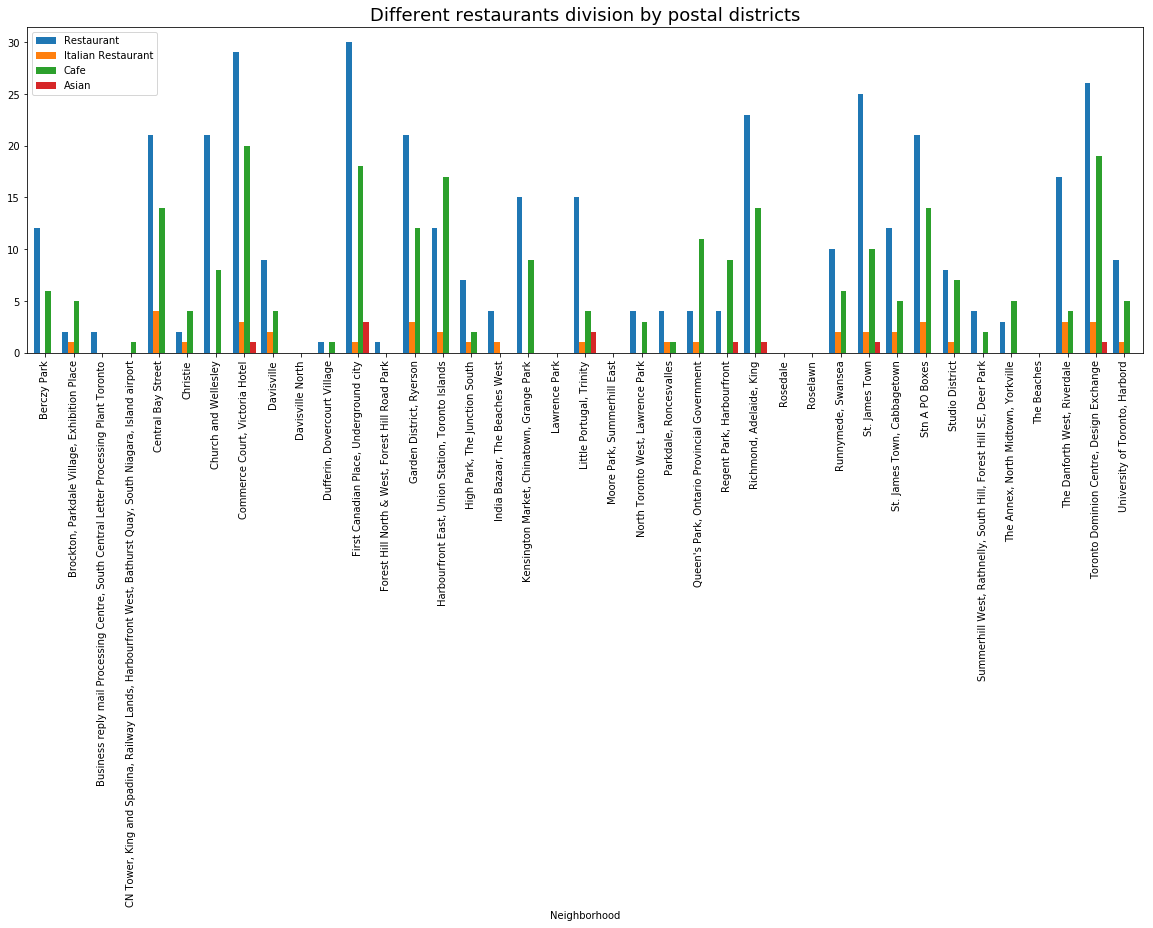

In [131]:
import matplotlib.pyplot as plt
ax1=toronto_rest.plot(x='Neighborhood',y=['Restaurant','Italian Restaurant','Cafe','Asian'], kind='bar',figsize = (20,6), width = 0.8)
ax1.set_title("Different restaurants division by postal districts", fontsize = 18)
plt.show()

#### Calculate % of restaurants areawise

In [132]:
totalrest = toronto_rest['Restaurant'].sum()
toronto_rest['rest_percent']=(toronto_rest['Restaurant']/totalrest)*100
totalrest=toronto_rest['Italian Restaurant'].sum()
toronto_rest['Italianrest_per']=(toronto_rest['Italian Restaurant']/totalrest)*100
totalrest=toronto_rest['Asian'].sum()
toronto_rest['Asian_per']=(toronto_rest['Asian']/totalrest)*100
toronto_rest.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Restaurant,Italian Restaurant,Cafe,Asian,rest_percent,Italianrest_per,Asian_per
0,Berczy Park,2487.751936,-4524.278465,12,0,6,0,3.174603,0.000000,0.0
1,"Brockton, Parkdale Village, Exhibition Place",1047.284333,-1906.276594,2,1,5,0,0.529101,2.564103,0.0
2,"Business reply mail Processing Centre, South C...",742.266646,-1348.466486,2,0,0,0,0.529101,0.000000,0.0
3,"CN Tower, King and Spadina, Railway Lands, Har...",698.063147,-1270.310718,0,0,1,0,0.000000,0.000000,0.0
4,Central Bay Street,3056.056668,-5557.116782,21,4,14,0,5.555556,10.256410,0.0


#### Read population data and clean it

In [143]:
url = 'https://en.wikipedia.org/wiki/Demographics_of_Toronto_neighbourhoods'
response = requests.get(url)
html = response.text
df_gtoronto = pd.read_html(html)
df_gtoronto= df_gtoronto[6]
df_gtoronto = df_gtoronto.drop(columns=['FM', 'Census Tracts', 'Density (people/km2)', '% Change in Population since 2001', 'Average Income', '% Renters', 'Second most common language (after English) by name', 'Second most common language (after English) by percentage', 'Map']).reset_index(drop=True)
df_gtoronto.rename(columns={'Name':'Neighborhood','Population':'Population', 'Land area (km2)': 'area'}, inplace=True)
df_gtoronto[1::].head()

,Neighborhood,Population,area,Transit Commuting %
1,Agincourt,44577.0,12.45,11.1
2,Alexandra Park,4355.0,0.32,13.8
3,Allenby,2513.0,0.58,5.2
4,Amesbury,17318.0,3.51,16.4
5,Armour Heights,4384.0,2.29,10.8


#### plot for population % and restauranet % for greater neighborhood

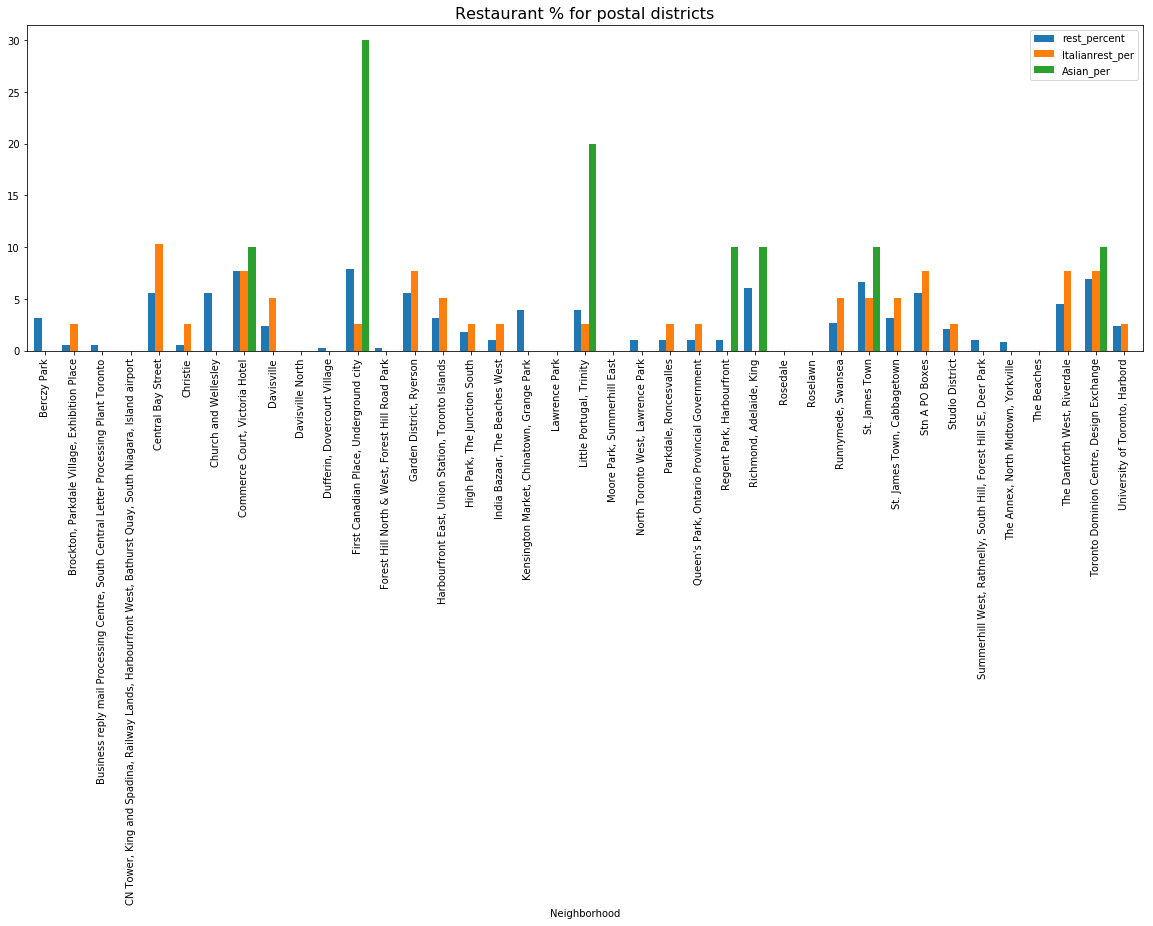

In [134]:
totalpopulation = df_gtoronto['Population'].sum()
df_gtoronto['population_per']=(df_gtoronto['Population']/totalpopulation)*100
df_gtoronto=df_gtoronto.merge(toronto_rest[['Neighborhood','rest_percent','Italianrest_per','Asian_per']], on='Neighborhood')
ax1=toronto_rest.plot(x='Neighborhood',y=['rest_percent','Italianrest_per','Asian_per'], kind='bar',figsize = (20,6), width = 0.8)
ax1.set_title("Restaurant % for postal districts", fontsize = 16)
plt.show()

In [135]:
def get_color(category):
    if 'Asian' in category:
        col = 'red'
    if 'Italian' in category:
        col = 'green'
    return col
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
toronto_plot = toronto_venues[toronto_venues['Venue Category'].str.contains('Asian') | toronto_venues['Venue Category'].str.contains('Italian')] 
for lat, lon,area, cat in zip(toronto_plot['Venue Latitude'], toronto_plot['Venue Longitude'],toronto_plot['Neighborhood'],toronto_plot['Venue Category']):
    folium.CircleMarker([lat, lon],
                        radius=5,
                        popup=area,
                        color=get_color(cat),
                        fill=True,
                        fill_color='#3186cc',
                        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)
    
map_toronto

In [136]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head(10)

,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,The Beaches,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0

In [138]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,Yoga Studio,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Workshop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beach,Bed & Breakfast,Beer Bar,Beer Store,Belgian Restaurant,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Butcher,Café,Cajun / Creole Restaurant,Candy Store,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Auditorium,College Cafeteria,College Gym,College Rec Center,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Harbor / Marina,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hospital,Hotel,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Korean Restaurant,Lake,Latin American Restaurant,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Mac & Cheese Joint,Market,Martial Arts Dojo,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Performing Arts Venue,Pet Store,Pharmacy,Pizza Place,Playground,Plaza,Poke Place,Poutine Place,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Restaurant,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shoe Store,Shopping Mall,Skate Park,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Stadium,Stationery Store,Steakhouse,Strip Club,Supermarket,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Women's Store
0,Berczy Park,0.000000,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.000000,0.000000,0.00,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.035088,0.000000,0.000000,0.00,0.017544,0.017544,0.000000,0.035088,0.000000,0.000000,0.017544,0.0000,0.000000,0.0000,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.035088,0.000000,0.000000,0.000000,0.035088,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632,0.070175,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.017544,0.000000,0.017544,0.000000,0.00,0.000000,0.000,0.017544,0.000000,0.000000,0.000000,0.000000,0.017544,0.000000,0.017544,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017544,0.0000

In [139]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [140]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Berczy Park,Coffee Shop,Cocktail Bar,Farmers Market,Café,Cheese Shop,Pharmacy,Bakery,Restaurant,Beer Bar,Seafood Restaurant
1,"Brockton, Parkdale Village, Exhibition Place",Café,Yoga Studio,Coffee Shop,Breakfast Spot,Bakery,Convenience Store,Performing Arts Venue,Pet Store,Climbing Gym,Restaurant
2,"Business reply mail Processing Centre, South C...",Light Rail Station,Park,Pizza Place,Smoke Shop,Brewery,Spa,Burrito Place,Farmers Market,Fast Food Restaurant,Restaurant
3,"CN Tower, King and Spadina, Railway Lands, Har...",Airport Service,Airport Terminal,Airport Lounge,Boat or Ferry,Coffee Shop,Harbor / Marina,Boutique,Sculpture Garden,Airport Gate,Airport Food Court
4,Central Bay Street,Coffee Shop,Sandwich Place,Italian Restaurant,Café,Japanese Restaurant,Salad Place,Bubble Tea Shop,Burger Joint,Department Store,Bar


## Analysis<a name="analysis"></a>
Overall Asian Restaurants have less existence in Toronto City. first canadian place, Underground city and Commerce court, Victoial hotel areas, region which has plenty of restaurants and cafe otherwise. Assuming Asian migrated peoples are settling in first canadian place, Underground city and Little portugal, Trinity postal districts majorly, hence Little portugal, Trinity can be a good potential area for Asian restaurant

## Conclusion<a name="conclusion"></a>
Little portugal, Trinity, Richmond, Adelaide, king and Regent park would be potential regions to open a Asian Restaurant.

Assuming increasing population in Richmond, Adelaide, king and Regent park region, Asian restaurants would have good potential in these areas of toronto